## Opis problema

Naš zadatak je da iz skupa podataka o pacijentima koji su podvrgnuti **elektrokonverziji** napravimo **klasifikacioni model** koji predviđa da li će procedura biti uspešna. 
U ovoj svesci predstavljeni su različiti modeli dobijeni primenom drveta odlučivanja, naivnog Bajesa, metode potpornih vektora i neuronskih mreža.

## Učitavanje podataka

Podaci su dimenzija **147 x 49**. Redovi predstavljaju pacijente indeksirane po broju iz baze, a atributi su karakteristike zdravstvenog stanja pacijenata i karakteristike primenjene elektrokonverzije. 
Ulazni atributi su celobrojnog tipa, a ciljni atribut (uspešnost elektrokonverzije) je istinitosnog tipa. Važno je napomenuti da je skup podataka **nebalansiran**: klasa *True (uspešna elektrokonverzija)* je zastupljena u 130 zapisa, dok je klasa *False (neuspešna elektrokonverzija)* zastupljena u svega 17 zapisa.

In [1]:
import pandas as pd 

df = pd.read_csv(
        'elektroprecisceno.csv',
         index_col=0
     )
df

,godine,stariji,Pol,indikacija:,ukupno,trajanje,frekvenca,Blok,dimenzija,EDD,...,Sotalol,Digoksin,ASA,OAKT,Plavix,Statin,Implantiran,Vreme,"sinhroni,",Elektrokonverzija
Broj,,,,,,,,,,,,,,,,,,,,,
1,78,1,1,1,5,5,0,3,42,56,...,0,0,0,2,0,0,1,2,2,True
2,61,0,1,2,24,1,7,0,42,59,...,0,0,0,2,0,0,0,-1,2,True
3,65,1,1,1,4,4,0,3,47,55,...,0,0,0,2,0,0,1,3,2,True
4,64,0,1,1,288,2,7,0,50,50,...,0,0,0,2,0,0,0,-1,2,True
5,65,1,2,1,48,3,9,0,49,61,...,0,0,0,2,0,1,0,-1,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,61,0,1,2,2,2,0,3,36,54,...,0,0,0,2,0,0,1,2,2,True
647,58,0,1,2,12,2,0,3,45,57,...,0,0,0,3,0,1,1,2,2,True
648,72,1,2,1,20,20,6,0,43,66,...,0,1,0,3,0,0,0,-1,2,True


## Podela podataka na trening i test

Skup podataka delimo na deo za treniranje modela i deo za testiranje dobijenog modela. Podela će se vršiti pre primene svakog od različitih algoritama kako bi se poništile moguće transformacije i kako bi za svaki bile izabrane odrednice kreiranja trening skupa. 

Prosleđeni argument *random_state* je postavljen na 0 jer se na taj način dobija uvek isto podeljen skup podataka, što je pogodno za upoređivanje modela. 
Argument *stratify* dobija vrednost ciljane kolone kako bi raspodela podataka u trening i test skupu ostala približno ista kao u početnom skupu, što je posebno važno jer je u pitanju nebalansirani skup. 
Koristi se i *sampler* za dodatno balansiranje u trening skupu. 

In [2]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

tts = train_test_split

def train_test_split(X, y, sampler=None, test=0.35):
    X_train, X_test, y_train, y_test = tts(X, y, random_state=0, stratify=y, test_size=test)
    
    if sampler is not None:
        X_train, y_train = sampler(random_state=0).fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test

## Kvalitet modela

Mera koja nam daje najviše informacija o kvalitetu modela je **balansirana tačnost** (*macro_avg*) koja predstavlja srednju vrednost odziva za svaku klasu. Korišćeni su **matrica konfuzije** (u vidu **toplotne mape**) i **izveštaj klasifikacije** koji nam pružaju uvid u različite osobine modela. Funkcija prijavljuje i loše klasifikovane neuspešne procedure. Prikazana je i **ROC kriva**, za koju važi da je površina ispod nje dobra mera uspeha binarnog klasifikatora.

In [3]:
from sklearn.metrics import roc_curve, auc, classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(y_true, y_pred, ax):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    pov = auc(fpr, tpr)
        
    ax.plot(fpr, tpr, color='red',
             lw=2, label=f'ROC kriva (površina = {pov:.2f})')
    
    ax.set_xlabel('Stopa lažno pozitivnih (FPR)')
    ax.set_ylabel('Stopa stvarno pozitivnih (TPR)')

    ax.set_title('ROC kriva')
    ax.legend(loc='lower right')

_, XXX, _, _ = train_test_split(X, y)

def kvalitet_modela(clf, X_test, y_test):
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    plot_confusion_matrix(clf, X_test, y_test, colorbar=False, cmap='Reds', ax=ax1)
    plot_roc_curve(y_test, y_pred, ax2) 
    plt.show()

    try:
        print('Greške:', XXX.iloc[np.where((y_pred != y_test) & ~y_test)].index.to_numpy())
    except:
        pass

## Stablo odlučivanja

**Stablo odlučivanja** je klasifikator koji u svakom unutrašnjem čvoru sadrži upit za određeni atribut na osnovu kog se pretraga dalje usmerava kroz adekvatne grane, u naredne čvorove. Za razliku od unutrašnjih čvorova, svakom listu je pridružena odgovarajuća klasa. Da bismo klasifikovali neki podatak na osnovu atributa se usmeravamo kroz stablo odgovarajućim granama, sve do lista koji će reći kojoj klasi podatak pripada.

Za treniranje i kreiranje modela stabla odlučivanja, zbog nebalansiranosti skupa podataka, prosleđen je parametar *class_weight* sa vrednošću *'balanced'* koja označava da su težine svake klase obrnuto srazmerne njihovoj zastupljenosti u skupu.

              precision    recall  f1-score   support

       False       0.40      0.33      0.36         6
        True       0.91      0.93      0.92        46

    accuracy                           0.87        52
   macro avg       0.66      0.63      0.64        52
weighted avg       0.86      0.87      0.86        52



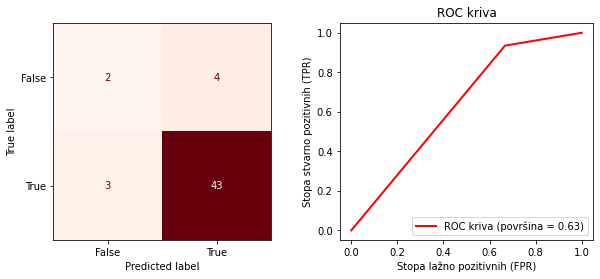

Greške: [636  63 312 320]


In [4]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y)

tree = DecisionTreeClassifier(random_state=0, class_weight='balanced')
tree.fit(X_train, y_train)

kvalitet_modela(tree, X_test, y_test)

## Skraćivanje stabla


Dobijeno stablo je u potpunosti prilagođeno trening podacima i ne pokazuje dovoljno dobre performanse nad test podacima. Zbog toga treba pokušati sa poboljšanjem modela **odsecanjem delova stabla**.
Korišćeno je odsecanje modifikacijom vrednosti parametra *ccp_alpha* gde se za veće vrednosti odseca veći broj čvorova.
Za različite vrednosti parametra ispitan je kvalitet dobijenog stabla (*balanced_accuracy_score*). Međutim, najbolji kvalitet se dobija za *alpha=0.0*, što znači da se *odsecanjem stabla ne dobijaju bolji rezultati*.

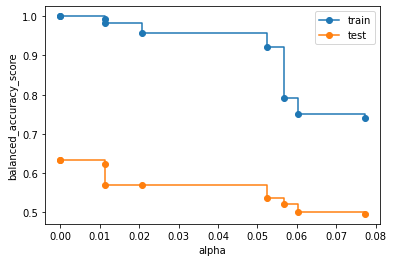

In [7]:
from sklearn.metrics import balanced_accuracy_score

ccp_alphas = tree.cost_complexity_pruning_path(X_train, y_train).ccp_alphas[:-1]

trees = []
for ccp_alpha in ccp_alphas:
    tree_pruned = DecisionTreeClassifier(random_state = 0, class_weight='balanced', ccp_alpha = ccp_alpha)
    tree_pruned.fit(X_train, y_train)
    trees.append(tree_pruned)

train_scores = [balanced_accuracy_score(y_train,tree_pruned.predict(X_train)) for tree_pruned in trees]
test_scores = [balanced_accuracy_score(y_test,tree_pruned.predict(X_test)) for tree_pruned in trees]

plt.xlabel('alpha')
plt.ylabel('balanced_accuracy_score')
plt.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
plt.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
plt.legend()

plt.show()

Konačno stablo odgovara početnom stablu s obzirom da modifikacije ne doprinose kvalitetu. Balansirana tačnost stabla iznosi $63\%$, pri čemu False klasi odgovara odziv $33\%$ što nije dovoljno dobro.
Konačno stablo prikazano je na slici ispod:

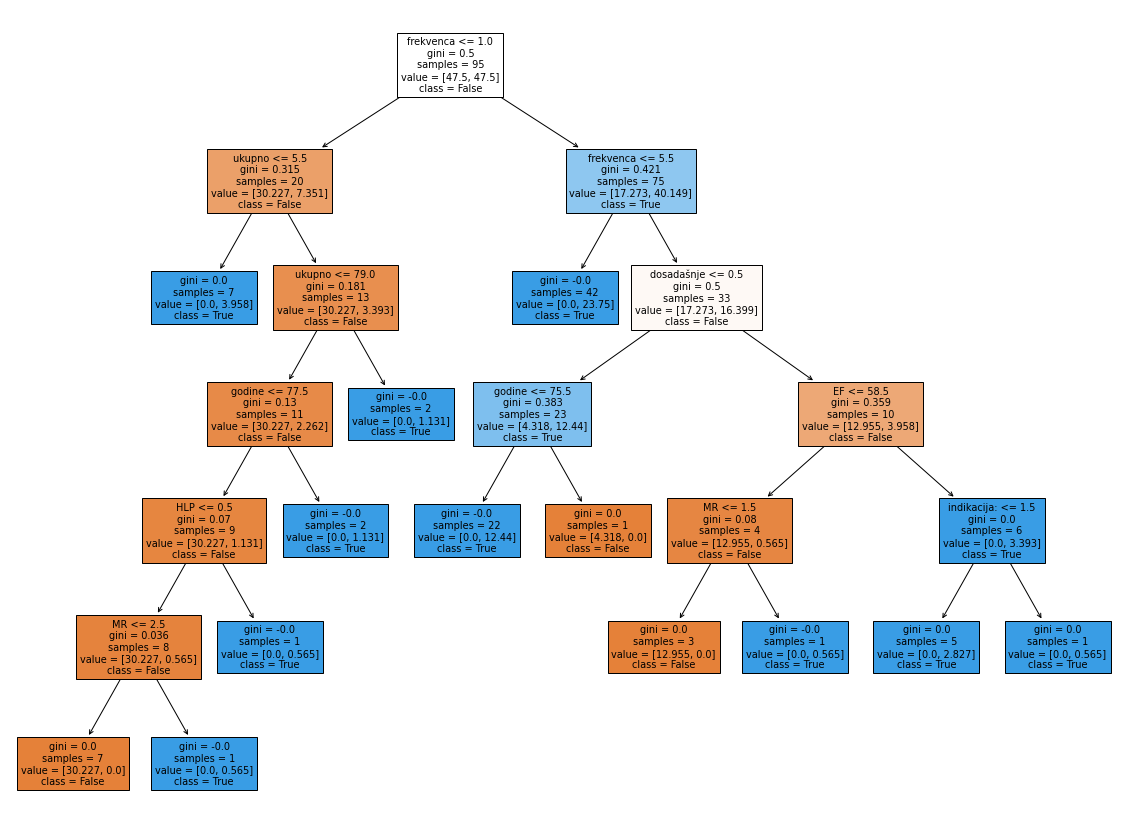

In [8]:
import sklearn.tree

fig = plt.figure(figsize=(20,15))
_ = sklearn.tree.plot_tree(tree, 
                           feature_names=X_train.columns,  
                           class_names=['False','True'],
                           filled=True)

## Ispitivanje povezanosti i značaj atributa 

Funkcija *permutation_importance* izračunava značaj atributa za klasifikator nad određenim skupom podataka. 
Značaj se izračunava kao smanjenje nečistoće čvora otežano verovatnoćom dosezanja tog čvora. Što je veća vrednost koja se dobije, to je atribut značajniji.

In [9]:
from sklearn.inspection import permutation_importance

importances = sorted(zip(tree.feature_importances_, X.columns), reverse=True)
for importance, column in importances:
    if importance >= 1e-06:
        print(f'{column} : {importance:.6f}')

frekvenca : 0.396828
godine : 0.177675
ukupno : 0.160366
EF : 0.104846
dosadašnje : 0.091570
MR : 0.046186
HLP : 0.022529


Dendrogram i toplotna mapa(heatmap) predstavljaju **korelacije između atributa**. Presekom napravljenim na dendrogramu moguće je napraviti selekciju atributa.

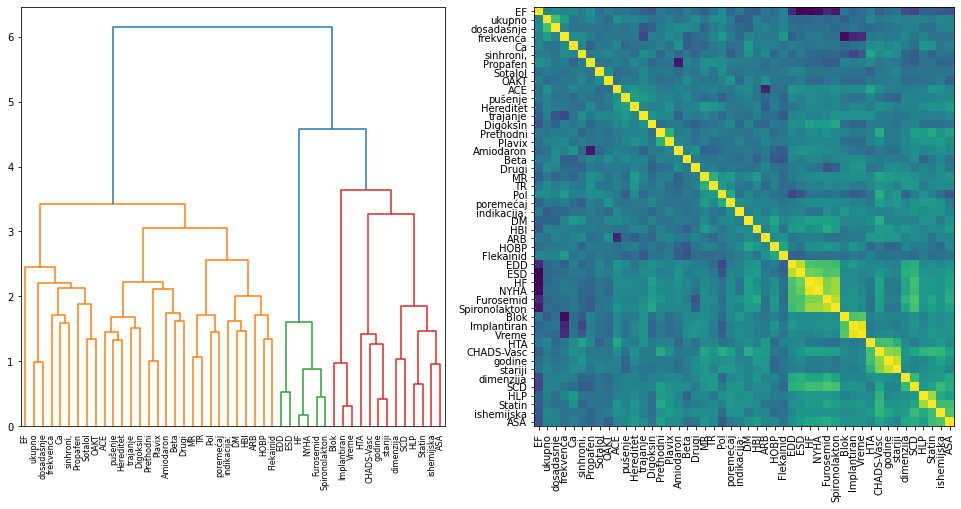

In [13]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.5, 7))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns.tolist(), ax=ax1)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

## Primena šume za klasifikaciju

**Slučajna šuma** odgovara kombinaciji različitih drveta odlučivanja na različitim poduzorcima skupa podataka. Nad rezultatima koje drveta odlučivanja koristi se usrednjavanje kako bi se poboljšala tačnost predviđanja i kontrolisalo preprilagođavanje. Veličina poduzoraka se kontroliše parametrom *max_samples*, ali samo ukoliko je parametar *bootstrap* postavljen na True (ukoliko je *bootstrap* postavljen na False ceo skup se koristi za izgradnju svakog drveta).

Kao i kod drveta odlučivanja, parametar *random_state* je fiksiran i težine klasa su balansirane.
Parametar *n_estimators* predstavlja broj stabala koji želimo da se kreira i na osnovu kojih se procenjuje konačan rezultat (uzima se srednja vrednost za svaku procenu). 
Ispitano je više vrednosti za *n_estimators* i *max_samples* i među njima najbolju balansiranu tačnost daju vrednosti u navedenom modelu.

              precision    recall  f1-score   support

       False       0.25      0.67      0.36         6
        True       0.94      0.74      0.83        46

    accuracy                           0.73        52
   macro avg       0.60      0.70      0.60        52
weighted avg       0.86      0.73      0.78        52



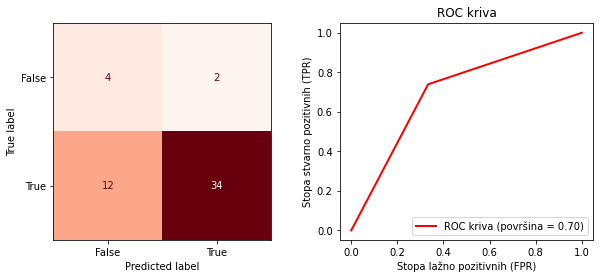

Greške: [636 320]


In [14]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0,
                                bootstrap=True, 
                                n_estimators=2,
                                max_samples=50,
                                class_weight='balanced')
forest.fit(X_train, y_train)
kvalitet_modela(forest, X_test, y_test)

## Naivni Bajes

Klasifikator **Naivni Bajes** procenjuje uslovnu verovatnoću klase sa pretpostavkom da su atributi međusobno nezavisni. Korelisani atributi mogu narušiti performanse naivnog Bajesovog klasifikatora jer narušavaju pretpostavku o nezavisnosti. Na toplotnoj mapi smo videli da postoje korelacije između određenih atributa, međutim njih nema mnogo pa ima smisla da ipak pokušamo sa upotrebom ovog klasifikatora.

Korišćena su dva drugačija klasifikatora, **GaussianNB** i **ComplementNB**. GaussianNB pretpostavlja da je raspodela atributa normalna. Zbog toga ćemo pre primene ovog klasifikatora podatke standardizovati.

Dobijen model GaussianNB klasifikatora za veličinu test skupa $35\%$ skoro sve podatke svrstava u False klasu. Može biti iskorišćena činjenica da model ne zahteva veliki trening skup kako bi pokazao dobre performanse, pa promenom veličine test skupa na $70\%$ dobijaju se nešto bolji rezultati. Međutim, oni i dalje nisu dovoljno dobri jer balansirana tačnost iznosi samo $48\%$, gde je odziv za obe klase približno $50\%$.

              precision    recall  f1-score   support

       False       0.11      0.42      0.17        12
        True       0.88      0.55      0.68        91

    accuracy                           0.53       103
   macro avg       0.49      0.48      0.42       103
weighted avg       0.79      0.53      0.62       103



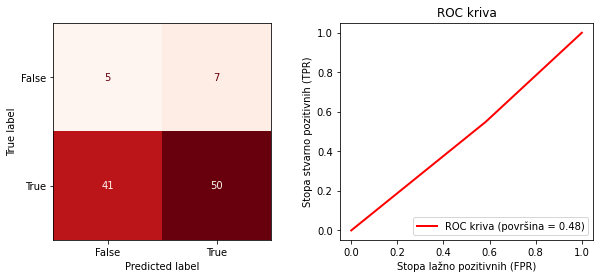

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X, y, test=0.7)

gnb = Pipeline([('std', StandardScaler()), ('gnb', GaussianNB())])
gnb.fit(X_train_g, y_train_g)

kvalitet_modela(gnb, X_test_g, y_test_g)

ComplementNB je dopuna MultionimalNB koji je posebno prilagođen nebalansiranim podacima. ComplementNB ne obrađuje negativne vrednosti atributa, pa je dodatno potrebno podatke skalirati tako da se svi nalaze u nekom pozitivnom opsegu.

Model ComplementNB klasifikatora sa RandomOverSampler pokazuje dosta bolje osobine jer balansirana tačnost sada iznosi $73\%$. Model ima vrlo slične performanse kao stablo odlučivanja, ali pogađa jednu dodatnu neuspešnu elektrokonverziju.

              precision    recall  f1-score   support

       False       0.60      0.50      0.55         6
        True       0.94      0.96      0.95        46

    accuracy                           0.90        52
   macro avg       0.77      0.73      0.75        52
weighted avg       0.90      0.90      0.90        52



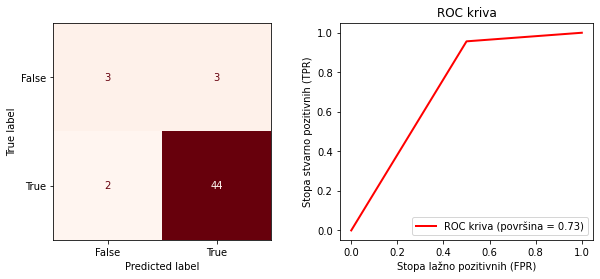

Greške: [  6  63 320]


In [18]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import ComplementNB

X_train_rand, _, y_train_rand, _ = train_test_split(X, y, RandomOverSampler)

cnb = Pipeline([('mms', MinMaxScaler()), ('cnb', ComplementNB())])
cnb.fit(X_train_rand, y_train_rand)
kvalitet_modela(cnb, X_test, y_test)

## Neuronska mreža

**Veštačka neuronska mreža** predstavlja simulaciju biološkog nervnog sistema jer ljudski mozak uči promenama jačina sinaptičkih veza između neurona nakon ponovljene simulacije istim impulsima.
Ona se sastoji od skupa čvorova koji simuliraju neurone i direktnih veza koje simuliraju sinaptičke veze. Promene težina direktnih veza odgovaraju promenama jačina sinaptičkih veza, a ulazni podaci odgovaraju impulsima.
Najjednostavniji model neuronske mreže je **perceptron**. Granica odlučivanja kod perceptrona je linearna hiperravan koja razdvaja podatke na dve klase. Iz toga razloga, perceptron nije odgovarajući za primenu kod ovog skupa podataka jer smo PCA analizom uvideli da podaci nisu linearno razdvojivi.
Zbog toga nam je potrebna **višeslojna neuronska mreža** koja modeluje kompleksnije odnose između ulaznih i izlaznih promenljivih. U sklearn-u klasa **MLPClassifier** implementira algoritam višeslojnih neuronskih mreža. Model je veoma osetljiv na razlike u opsege podataka, pa je podatke potrebno je skalirati pre treniranja modela.

In [16]:
_ = '''
X_train, X_test, y_train, y_test = train_test_split(X, y, RandomOverSampler)

std_scaler = StandardScaler()  
std_scaler.fit(X_train)  
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)
'''

## Određivanje parametara metoda

GridSearchCV je funkcija koja implementira iscrpnu pretragu nad specifikovanim vrednostima parametara klasifikatora. Parametri se optimizuju unakrsnom validacijom nad mrežom parametara.
Za funkciju ocenjivanja modela korišćene su balansirana tačnost i površina ispod roc krive sa akcentom na balansiranoj tačnosti. 

Parametri potrebni za višeslojnu neuronsku mrežu: <br>
**hidden_layer_sizes** - broj čvorova u skrivenim slojevima <br>
**activation** - određuje aktivacionu funkciju za skriveni sloj <br>
**solver** - rešavač za optimizaciju težina <br>
**alpha** - regularizacioni parametar, kontroliše preprilagođavanje <br>
**learning_rate** - način na koji se menja stopa učenja kroz iteracije algoritma <br>
**learning_rate_init** - početna vrednost stope/brzine učenja <br>
**power_t** - parametar za slučaj da je stopa učenja inverzno skaliranje <br>

In [17]:
_ = '''
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='sgd',
                    max_iter=400,
                    random_state=0)

param_grid = [{
    'hidden_layer_sizes':[(6,4),(10,5),(15,10)],
    'activation':['relu','tanh'],
    'alpha':[0.0001,0.001,0.005],
    'batch_size':[1,10,50],
    'power_t':[0.3,0.5,0.7],
    'learning_rate':['constant','invscaling', 'adaptive'],
    'learning_rate_init':[0.001,0.01]
}]

grid = RandomizedSearchCV(estimator=mlp, 
                          param_distributions=param_grid, 
                          cv=3,
                          refit='balanced_accuracy',
                          scoring= ['roc_auc','balanced_accuracy'])

grid.fit(X_train, y_train)
'''

In [18]:
_ = '''
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=400,
                    random_state=0)

param_grid = [{
    'hidden_layer_sizes':[(6,4),(10,5),(15,10)],
    'activation':['relu','tanh'],
    'solver':['adam','lbfgs'],
    'batch_size':[1,5,10],
    'alpha':[0.0001,0.001,0.005],
    'learning_rate_init':[0.001,0.01,0.1]
}]

grid = RandomizedSearchCV(estimator=mlp, 
                    param_distributions=param_grid, 
                    cv=3,
                    refit='balanced_accuracy',
                    scoring= ['roc_auc','balanced_accuracy'])

grid.fit(X_train, y_train)
'''

## Kreiranje i primena neuronske mreže

Neuronska mreža se kreira sa parametrima dobijenim funkcijom GridSearchCV, kao i uz RandomOverSampler. 
Finalna neuronska mreža dobijena je kombinovanjem različitih pokretanja funkcije GridSearchCV.

Dobijeni model za svaku pojedinačnu kombinciju parametara dobijenu iz mreže parametara pokazuje manju balansiranu tačnost nego dobijenu unakrsnom validacijom. 
Balansirana tačnost iznosi $76\%$, pri čemu je odziv za *False* klasu jednak $67\%$, a za *True* klasu $85\%$.
Nakon primene balansiranja trening skupa pomoću RandomOverSampler dobijen je kvalitetniji model.

              precision    recall  f1-score   support

       False       0.36      0.67      0.47         6
        True       0.95      0.85      0.90        46

    accuracy                           0.83        52
   macro avg       0.66      0.76      0.68        52
weighted avg       0.88      0.83      0.85        52



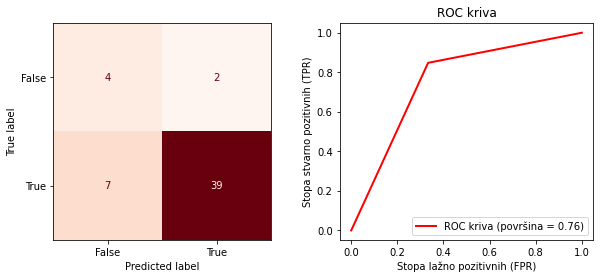

Greške: [636  33]


In [19]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='sgd',
                    activation='tanh',
                    hidden_layer_sizes=(15,10),
                    learning_rate='invscaling',
                    learning_rate_init=0.001,
                    power_t = 0.6,
                    batch_size=5,
                    max_iter=400,
                    random_state=0)
mlp = Pipeline([('std', StandardScaler()), ('mlp', mlp)])

mlp = mlp.fit(X_train_rand, y_train_rand)
kvalitet_modela(mlp, X_test, y_test)

## Metoda potpornih vektora

Granica odlučivanja kojoj klasi podatak pripada predstavljena je podskupom trening podataka: **potpornim vektorima**. 
Suština metoda je određivanje **maksimalne margine hiperravni**. Kada je margina mala, model je podložniji preprilagođavanju i slabo generalizuje nad novim podacima. 
**Nelinearni SVM** se primenjuje na linearno nerazdvojive skupove podataka, a klasa koja mu odgovara u sklearn-u je **SVC** koji će biti ovde primenjen.

In [20]:
from imblearn.over_sampling import ADASYN

X_train_ada, _, y_train_ada, _ = train_test_split(X, y, ADASYN)

## Izbor parametara metoda

Za izbor parametara je ponovo korišćena funkcija GridSearchCV sa istim osobinama.

Parametri potrebni za metodu potpornih vektora: <br>
**C** - vrednost penala za granicu odlučivanja sa velikom vrednošću promenljive popuštanja <br>
**kernel** - tip kernel funkcije za transformaciju prostora <br>
**gamma** - koeficijent kernel funkcije <br>
**coef0** - koeficijent kernel funkcije <br>
**degree** - koeficijent kernel funkcije (samo za 'poly') <br>


In [21]:
_ = '''
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC(random_state=0,
          class_weight='balanced')

param_grid = [{
   'C':[0.1, 0.5, 1.0],
   'kernel': ['linear','poly','rbf','sigmoid'],   
   'gamma':['scale','auto'],
   'coef0':[0.3,0.5,0.7,0.9],
   'degree':[1,2,3,4,5,6,7],
}]

grid = GridSearchCV(estimator=svc, 
                    param_grid=param_grid, 
                    cv=5,
                    refit='balanced_accuracy', 
                    scoring= ['balanced_accuracy','roc_auc'])

grid.fit(X_train, y_train)
'''

## Kreiranje modela 

Klasifikator potpornih vektora se kreira sa parametrima dobijenim pomoću funkcije GridSearchCV, kao i ASASYN oversamplera. 
Pretraga parametara pozvana je nad neizmenjenim skupom za trening i nad balansiranim skupom za trening.
Oprobana su oba modela, a predstavljeni pokazuje bolje osobine. Dodatno, izmenjen je parametar degree i dobijen je bolji model.
Balansirana tačnost sada iznosi $70\%$, pri čemu je odziv *False* klase $67\%$, a *True* klase $74\%$. 

              precision    recall  f1-score   support

       False       0.25      0.67      0.36         6
        True       0.94      0.74      0.83        46

    accuracy                           0.73        52
   macro avg       0.60      0.70      0.60        52
weighted avg       0.86      0.73      0.78        52



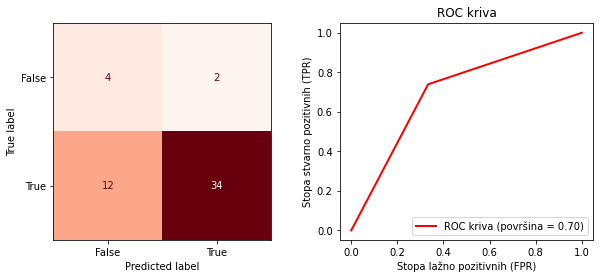

Greške: [ 6 63]


In [23]:
from sklearn.svm import SVC

# GridSearchCV nad neizmenjenim trening skupom: {'C': 0.1, 'coef0': 0.5, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
# GridSearchCV nad balansiranim trening skupom: {'C': 1.0, 'coef0': 0.3, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

svc = SVC(kernel='poly',
          C = 0.1,
          coef0 = 0.5,
          degree= 3,
          gamma='scale',
          class_weight='balanced')
svc = Pipeline([('std', StandardScaler()), ('svc', svc)])

svc = svc.fit(X_train_ada, y_train_ada)
kvalitet_modela(svc, X_test, y_test)

## Ansambl metoda

Kako su se dosad slučajna šuma i komplementarni naivni Bajes prikazali kao relativno uspešni, a pritom prave samo jednu zajedničku grešku, ima smisla napraviti **ansambl** koji spaja ova dva klasifikatora. Za funkciju odlučivanja može se uzeti pomnožena funkcija odlučivanja ova dva klasifikatora – pacijentu se dodeljuje klasa True samo ako oba člana ansambla tako misle. Ovo je po svim parametrima najbolji rezultat trenutno.

              precision    recall  f1-score   support

       False       0.29      0.83      0.43         6
        True       0.97      0.74      0.84        46

    accuracy                           0.75        52
   macro avg       0.63      0.79      0.64        52
weighted avg       0.89      0.75      0.79        52



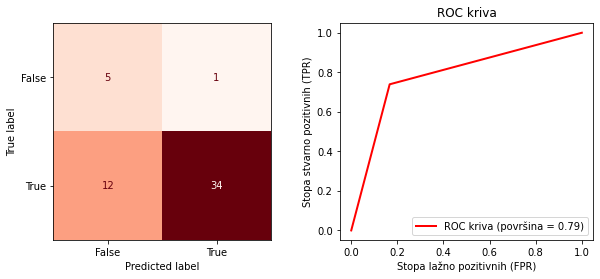

Greške: [320]


In [46]:
import warnings
from mlxtend.classifier import EnsembleVoteClassifier

forcnb = EnsembleVoteClassifier([forest, cnb], fit_base_estimators=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    forcnb.fit(_, y_train)

kvalitet_modela(forcnb, X_test, y_test)

Balansiranjem trening skupa dobijen je kvalitetniji model neuronskih mreža koji takođe može biti iskorišćen u ansamblu sa komplementarnim naivnim Bajesom, jer sa njim nema zajedničkih grešaka. Ovaj model je još bolji po svim parametrima najbolji i sveukupno najbolji.

              precision    recall  f1-score   support

       False       0.46      1.00      0.63         6
        True       1.00      0.85      0.92        46

    accuracy                           0.87        52
   macro avg       0.73      0.92      0.77        52
weighted avg       0.94      0.87      0.88        52



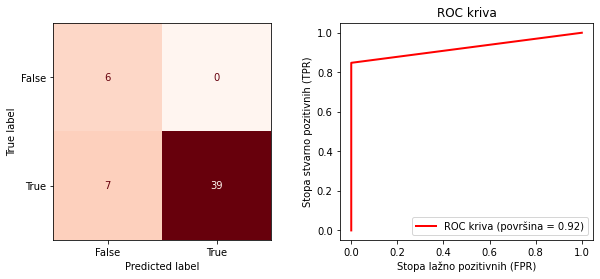

Greške: []


In [47]:
mlpcnb = EnsembleVoteClassifier([mlp, cnb], fit_base_estimators=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mlpcnb.fit(_, y_train)

kvalitet_modela(mlpcnb, X_test, y_test)